### **Análisis Exploratorio de los datos**

#### **Cargue del Dataframe, limpieza e imputaciones**

In [1]:
# Importación de Librerías y lectura del Dataframe
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

dir = 'Taller 3/resources/Dengue_Data.xlsx'
df = pd.read_excel(dir,engine='openpyxl',sheet_name = 'datos')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50397 entries, 0 to 50396
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   edad_                          50397 non-null  int64  
 1   Grupos edad                    50397 non-null  object 
 2   sexo_                          50397 non-null  object 
 3   area_1                         50397 non-null  object 
 4   area_2                         50397 non-null  object 
 5   area_                          50397 non-null  object 
 6   ocupacion_                     50397 non-null  object 
 7   per_etn_                       50397 non-null  object 
 8   gp_discapa                     49661 non-null  object 
 9   gp_desplaz                     49676 non-null  object 
 10  gp_migrant                     49696 non-null  object 
 11  gp_carcela                     49681 non-null  object 
 12  gp_gestan                      24841 non-null 

Number of object columns: 42


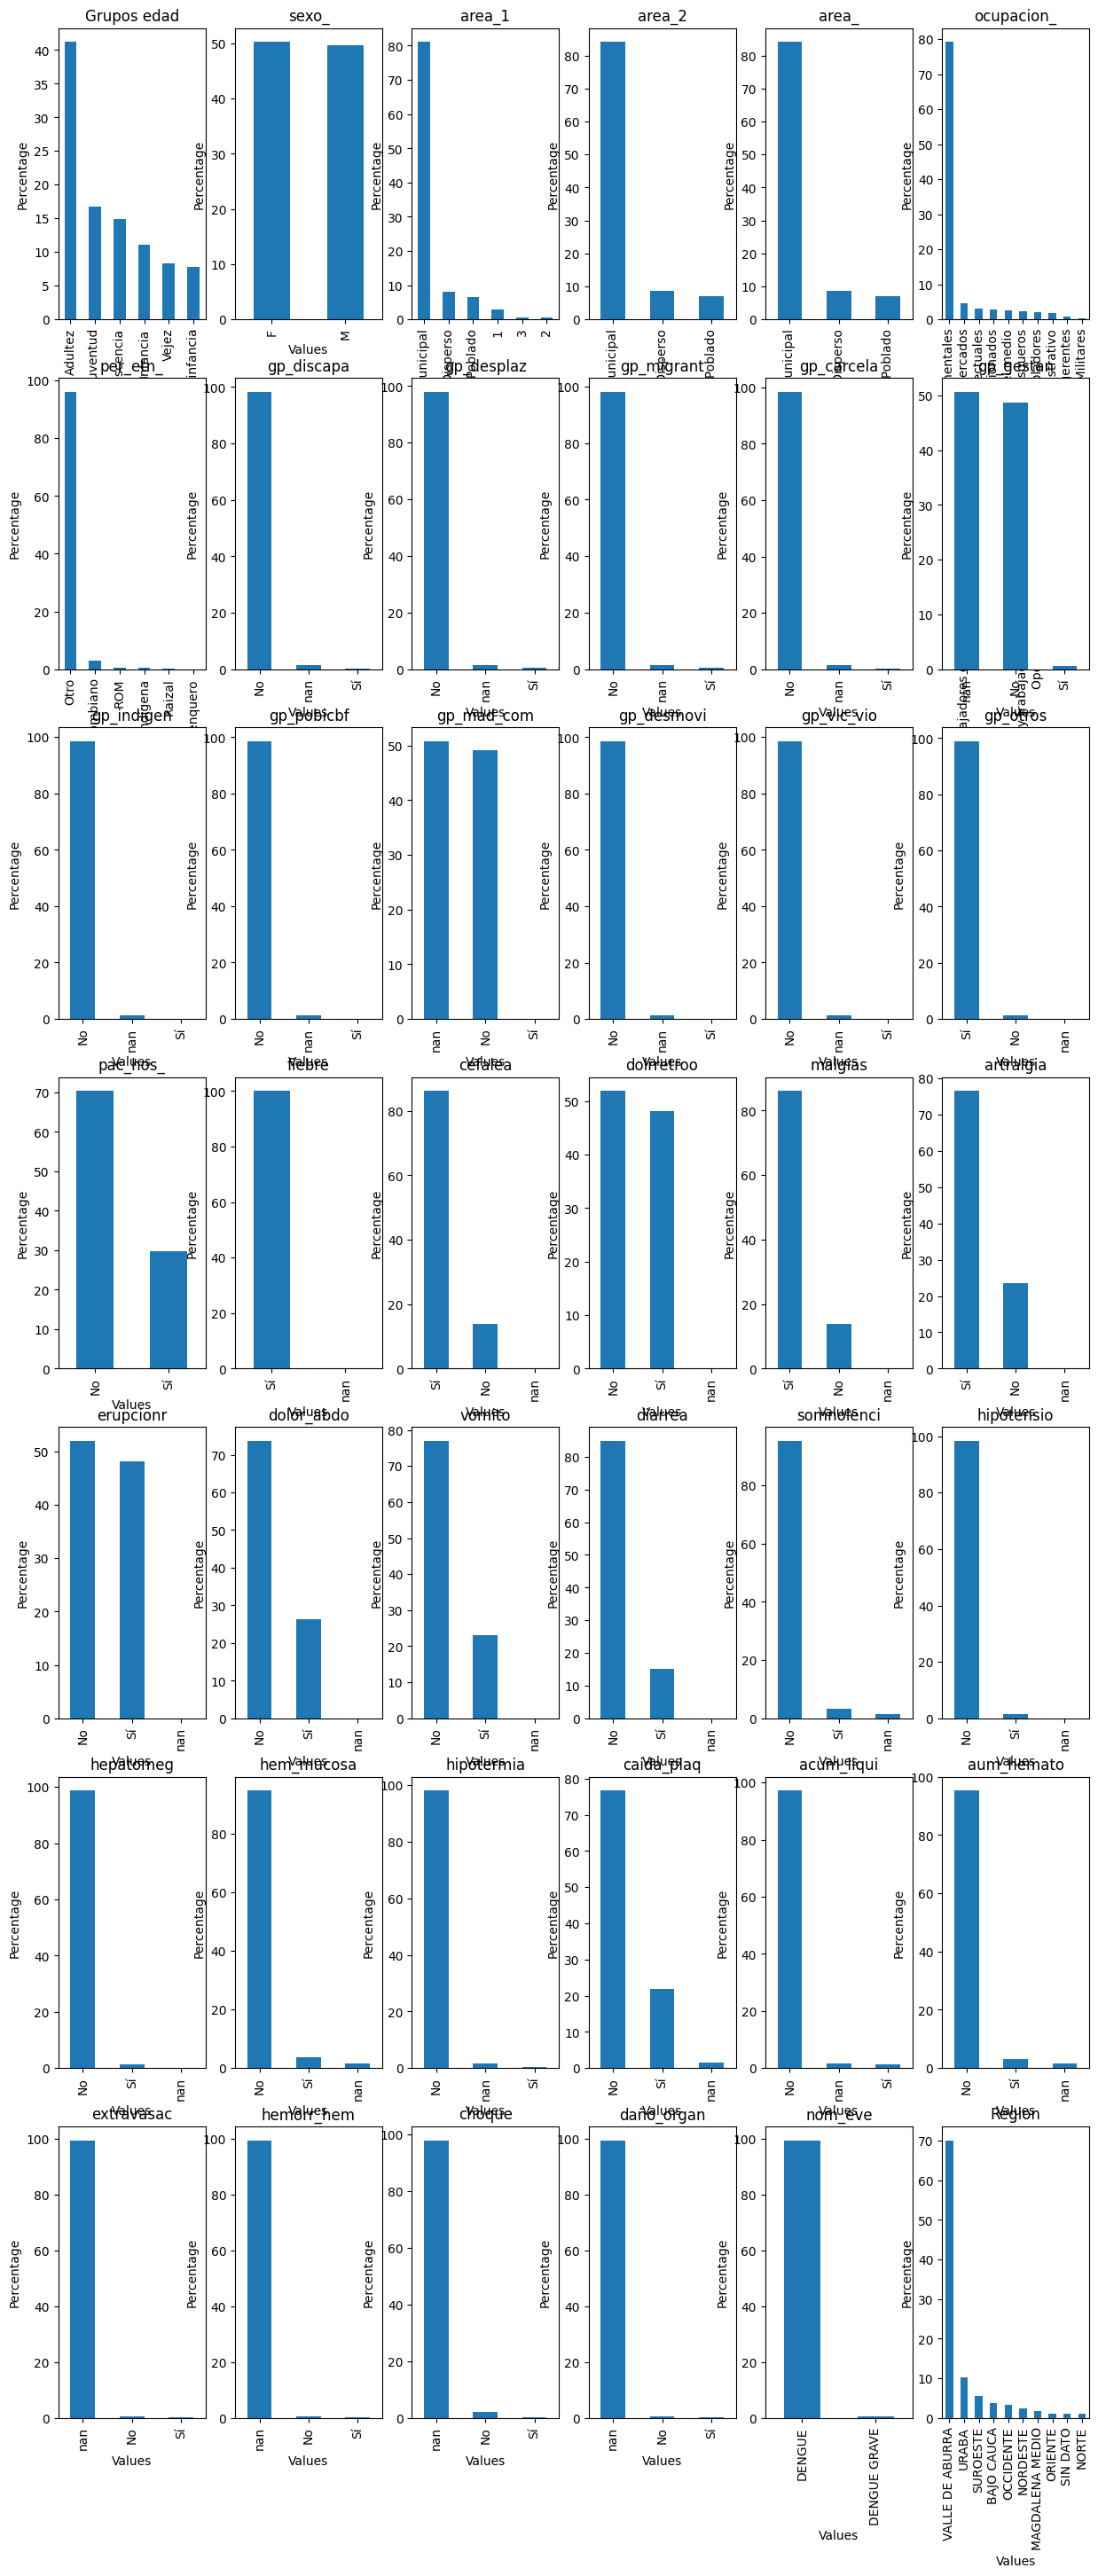

In [2]:
# Identificar columnas de tipo object
object_columns = df.select_dtypes(include=['object']).columns
print(f"Number of object columns: {len(object_columns)}")

# Calcular el número de filas y columnas para la matriz de subplots
num_cols = 6  # Número de columnas en la matriz de subplots
num_rows = (len(object_columns) + num_cols - 1) // num_cols  # Número de filas en la matriz de subplots

# Crear gráficos de porcentaje para cada columna de tipo object en una matriz de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

for i, col in enumerate(object_columns):
    value_counts = df[col].value_counts(dropna=False)
    percentage = (value_counts / len(df)) * 100
    percentage.plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel('Values')

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
del axes, col, fig, num_cols, num_rows, object_columns, percentage, value_counts, i # Eliminar variables no necesarias

Se puede observar que la mayoria de variables son Categóricas. Se identifica y seleccionan las variables relevantes dentro de los 2 grupos (variables socio-demográficas y variables clínicas). 

Las siguientes columnas se eliminan bajo los siguientes criterios:
- **area_1**: Misma información de la columna area.
- **area_2**: Misma información de la columna area.
- **gp_mad_com**: No se tiene contexto sobre la columna y el 51% de los datos estan vacíos.
- **tpo_consulta(consulta-inicio)**: No se tiene contexto sobre la columna.
- **fiebre**: 99,98% de los datos estan marcados como SI, los demás vacíos, lo que indica que sobre todas las personas que hacen parte de la muestra tienen fiebre y al no tener variabilidad sobre esta columna no influye / impacta sobre el modelo.
- **extravasac**: El 99% de la columna viene vacia y no hay criterio claro para imputación.
- **hemorr_hem**: El 99% de la columna viene vacia y no hay criterio claro para imputación.

In [3]:
# Columnas innecesarias
col_eliminar = ['area_1', 'area_2', 'gp_mad_com', 'tpo_consulta(consulta-inicio)', 'fiebre', 'extravasac', 'hemorr_hem']
# Columnas de interés separadas por categorías
col_soc_demograficas = ['edad',
                        'Grupos edad',
                        'sexo', 'area',
                        'ocupacion',
                        'per_etn',
                        'gp_discapa',
                        'gp_desplaz',
                        'gp_migrant',
                        'gp_gestan',
                        'gp_pobicbf',
                        'gp_desmovi',
                        'gp_vic_vio',
                        'gp_otros']
col_clinicas = ['fec_con',
                'ini_sin',
                'pac_hos',
                'fec_hos',
                'tpo_deterioro(hosp-consul)',
                'cefalea',
                'dolrretroo',
                'malgias','artralgia',
                'erupcionr',
                'dolor_abdo',
                'vomito',
                'diarrea',
                'somnolenci',
                'hipotensio',
                'hepatomeg',
                'hem_mucosa',
                'hipotermia',
                'caida_plaq',
                'acum_liqui',
                'aum_hemato',
                'choque',
                'daño_organ']

# Alistamiento del Dataset
df.rename(columns=lambda x: x.rstrip('_'), inplace=True)
df.drop(inplace=True,columns=col_eliminar) # Eliminar columnas innecesarias

# Imputación de valores faltantes
df.loc[(df['sexo'] == 'M') & (df['gp_gestan'].isnull()), 'gp_gestan'] = 'No'        # Se reemplazan los valores nulos de gp_gestan por 'No' si el sexo es Masculino

### **Parte A - Predecir Dengue o Dengue Grave a partir de Variables Socio-demográficas**

#### **Depuración del Dataframe**
Inicialmente, se depuran las columnas de interés y se eliminan registros vacíos para el estudio 

In [4]:
df1 = df.copy() # Crear una copia del DataFrame original
df1.drop(inplace=True,columns=col_clinicas) # Eliminar columnas innecesarias
print(f'Registros del Dataframe Original: {df1.shape[0]}')

# Eliminar registros con datos nulos
df1.dropna(inplace=True)
print(f'Registros del Dataframe Eliminando nulos en columnas de interés: {df1.shape[0]}')


Registros del Dataframe Original: 50397
Registros del Dataframe Eliminando nulos en columnas de interés: 49475


#### **Dummificación de variables categoricas (binarias, ordinales y nominales)**


In [5]:
col_binarias = ['sexo', 'gp_discapa', 'gp_desplaz', 'gp_migrant', 'gp_carcela', 'gp_gestan', 'gp_indigen', 'gp_pobicbf', 'gp_desmovi', 'gp_vic_vio', 'gp_otros','nom_eve']
col_ordinales = ['Grupos edad']	
col_nominales = ['area', 'ocupacion', 'per_etn', 'Region']

print(f'Dimensionalidad del Dataframe ANTES de aplicar label / One hot encoding: {df1.shape}')
# Label Encoding para columnas binarias
le = LabelEncoder()
for col in col_binarias:
    df1[col] = le.fit_transform(df1[col])

# Label Encoding para Grupos Edad
orden = ['Primera infancia', 'Infancia', 'Adolescencia', 'Juventud', 'Adultez', 'Vejez']
le_ordinal = LabelEncoder()
le_ordinal.fit(orden)
df1['Grupos edad'] = le_ordinal.transform(df1['Grupos edad'])

df1 = pd.get_dummies(df1, columns=col_nominales, dtype=int)
del le, le_ordinal, col_binarias, col_nominales, col_ordinales, orden, col # Eliminar variables no necesarias
print(f'Dimensionalidad del Dataframe DESPUÉS de aplicar label / One hot encoding: {df1.shape}')

Dimensionalidad del Dataframe ANTES de aplicar label / One hot encoding: (49475, 18)
Dimensionalidad del Dataframe DESPUÉS de aplicar label / One hot encoding: (49475, 43)


#### **Balanceo de Dataframe para Entrenar el modelo**
Una vez aplicada la Dummyficación de variables, se procede a analizar la variable objetivo "NOM_EVE"

In [6]:
df1['nom_eve'].value_counts()

nom_eve
0    49205
1      270
Name: count, dtype: int64

Se puede observar que el Dataset en la variable objetivo se encuentra enormemente desbalanceado, y no significa que esté mal, es el comportamiento natural del fenomeno estudiado, sin embargo, para usos prácticos y mejores resultados del modelo, se opta por balancear el conjunto de datos de Entrenamiento de la siguiente forma:

- **Conjunto de datos de Entrenamiento:**
    - Registros con variable Objetivo 0 (Dengue): 216
    - Registros con variable Objetivo 1 (Dengue Grave): 216 (80% de registros con este valor)

- **Conjunto de datos de Pruebas:**
    - Registros con variable Objetivo 0 (Dengue): 48.989
    - Registros con variable Objetivo 1 (Dengue Grave): 54 (20% de registros con este valor)


In [ ]:
# Dividir los datos en entrenamiento y prueba

# Seleccionar los primeros 216 registros con 'nom_eve' = 0 y 'nom_eve' = 1 
dengue_train = df1[df1['nom_eve'] == 0].head(216)
dengue_grave_train = df1[df1['nom_eve'] == 1].head(216)
train_data = pd.concat([dengue_train, dengue_grave_train])

# Definir X_train y y_train
X_train = train_data.drop(columns=['nom_eve'])
y_train = train_data['nom_eve']

# Calcular Test Data
test_data = df1.drop(train_data.index)
X_test = test_data.drop(columns=['nom_eve'])
y_test = test_data['nom_eve']

# Verificación de balance en el conjunto de entrenamiento y prueba
print("Distribución en el conjunto de entrenamiento:")
print(y_train.value_counts())
print("\nDistribución en el conjunto de prueba:")
print(y_test.value_counts())

del dengue_train, dengue_grave_train, train_data, test_data # Eliminar variables no necesarias

Distribución en el conjunto de entrenamiento:
nom_eve
0    216
1    216
Name: count, dtype: int64

Distribución en el conjunto de prueba:
nom_eve
0    48989
1       54
Name: count, dtype: int64
